##**1. Importación de librerías y descarga de recursos**




In [1]:
!pip install pysentimiento
# Ejecutar en terminal antes: python -m spacy download es_core_news_sm
!python -m spacy download es_core_news_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 68.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [143]:
import pandas as pd # Librería para creación y proceasmiento de dataframes
import numpy as np  # Librería para manipulación de arrays
import re # Expresiones regulares para limpieza de datos
import nltk # PLN
from nltk.corpus import stopwords #
from nltk.tokenize import word_tokenize # Tokenización (división del texto en unidades inferiores de procesamiento)
from sklearn.feature_extraction.text import TfidfVectorizer # Vectorización (conversión de las "palabras" en números)
from sklearn.naive_bayes import MultinomialNB # Módulo de sklearn (ML) para implementar modelos de Native Bayes
from sklearn.model_selection import train_test_split # Módulo de sklearn para divisir el dataset en datos de entrenamiento y validación
from sklearn.decomposition import LatentDirichletAllocation # Módulo de sklearn para analizar tópicos
from sklearn.metrics import  f1_score, classification_report # Módulo de sklearn para aplicar métricas de rendimiento sobre los modelos
from textblob import TextBlob #Análisis de sentimientos
from  pysentimiento import create_analyzer # Librería alternativa a TextBlob especializada en lengua española
import spacy # Lemantización
from tqdm import tqdm # Permite definir el método apply dinámico
import sys # Librería que permite manipular paths
import matplotlib.pyplot as plt # Librería para creación de gráficos
import seaborn as sns # Librería para creación de gráficos basada en matplotlib
import joblib # Librería para guardar modelos entrenados
from google.colab import files # Librería para descargar archivos generados

In [21]:
# Descargar recursos de NLTK necesarios
nltk.download('punkt') # Recurso encargado de tokenizar (división del texto en unidades más pequeñas, normalmente palabras)
nltk.download('stopwords') # Recurso que contiene palabras muy comunes que no aportan significado temático por sí solas.
nltk.download('punkt_tab') # Recurso que asegura la compatibilidad del sistema de división de palabras y frases.

#

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
# Ejecutar en terminal antes: python -m spacy download es_core_news_sm
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 33.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [16]:
# Ejecutar en terminal antes: python -m spacy download es_core_news_sm
try:
    nlp = spacy.load("es_core_news_sm") # Descargamos un modelo pre-entrenado en español
except:
    print("Spacy model non found. Execute: python -m spacy download es_core_news_sm")

#**2. Importación de los ficheros csv y generación del dataframe general**

In [5]:
# Leemos los ficheros csv generados previamente con el notebook "extraccion" ubicados en el respositorio de github
# Pasamos los datos a dataframes de pandas, añadimos una columna "source" donde indicamos el origen de los mensajes cargados
url_base_github = 'https://raw.githubusercontent.com/rsolis-utamed/pln_practica/main'
url_data=f"{url_base_github}/data"

data_sources=['cotilleando','minube','forocoches']
file_1_name = f'data_{data_sources[0]}.csv'
file_2_name = f'data_{data_sources[1]}.csv'
file_3_name= f'data_{data_sources[2]}.csv'
#

df_1 = pd.read_csv(f'{url_data}/{file_1_name}', on_bad_lines='skip', encoding='utf-8')
df_1['source']=data_sources[0]
df_2 = pd.read_csv(f'{url_data}/{file_2_name}', on_bad_lines='skip', encoding='utf-8')
df_2['source']=data_sources[1]
df_3 = pd.read_csv(f'{url_data}/{file_3_name}', on_bad_lines='skip', encoding='utf-8')
df_3['source']=data_sources[2]

In [6]:
# Unificamos los 3 dataframes en un único datagrame general
df_combined = pd.concat([df_1, df_2, df_3], ignore_index=True)
display(df_combined.head())

,Mensaje,source
0,"Pues eso... Así literal, para mi gusto Málaga ...",cotilleando
1,"Qué pena, de verdad, hace que no voy unos seis...",cotilleando
2,"me da pena lo que dices, pase un par de temmpo...",cotilleando
3,No puedo evitar tomármelo a lo personal (hasta...,cotilleando
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",cotilleando


#**3. Preprocesamiento**

In [62]:
# Palabras encontradas en topicos generados anteriormente (en pruebas previas) que se ha considearo que no aportan valor. Se incorporan dentro de
# el resto de stopwords
ruido_nuevo = ['él', 'decir', 'dejar', 'cada', 'dar', 'año', 'pasar','alguno', 'claro', 'igual', 'siempre', 'vez', 'medio']

In [63]:
# Visualizamos los 5 tópicos generados y sus 10 palabras más relevantes
for idx, topic in  enumerate(lda_model.components_):
    print(f"Tópico {nombre_topicos[idx]}: ", [feature_names[i] for i in topic.argsort()[:-11:-1]])

Tópico Mercado Inmobiliario y Barrio:  ['precio', 'solo', 'luz', 'oeste', 'subir', 'buscar', 'zona', 'piso', 'ahora', 'tal']
Tópico Problemática Social y Empleo:  ['él', 'ronda', 'bien', 'restaurante', 'centro', 'hacer', 'ciudad', 'visitar', 'tienda', 'encontrar']
Tópico Gestión Urbana y Limpieza:  ['ser', 'málaga', 'aquí', 'alquiler', 'españa', 'calle', 'ciudad', 'dónde', 'pena', 'lario']
Tópico Sentimiento e Identidad General:  ['zona', 'asperón', 'haber', 'piso', 'vivir', 'querer', 'shur', 'ver', 'bien', 'jardin']
Tópico Turismo y Ocio:  ['ser', 'mas', 'haber', 'vas', 'ciudad', 'tener', 'zona', 'málaga', 'poder', 'ver']


In [7]:
# Desargamos el respositorio donde tenemos el código (Lo vamos a emplear para ejecutar la clase Preprocessor.py)
!git clone https://github.com/rsolis-utamed/pln_practica.git

Cloning into 'pln_practica'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (35/35), done.
Receiving objects: 100% (45/45), 20.06 KiB | 10.03 MiB/s, done.
remote: Total 45 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Resolving deltas: 100% (7/7), done.


In [18]:
#Actualizamos el el contenido del repositorio (si procede)
!cd /content/pln_practica && git pull

Already up to date.


In [13]:
# Definimos un path para poder trabajar con scripts python subidos al respositorio
sys.path.append('/content/pln_practica/code')

In [64]:
# Importamos la clase propia preprocessor del reposistorio github
from Preprocessor import Preprocessor
tqdm.pandas() # Este paso nos permite aplcar "process_apply" en lugar de apply genérico. Nos ofrece de forma dinámia el porcentaje de ejecución del proceso.
preprocesador=Preprocessor(nlp,ruido_nuevo)
col_texto='Mensaje' # Nombre que posee la columna con los comentarios en los ficheros csv que componen el corpus
print("Preprocesando textos...")
df_combined['texto_limpio'] = df_combined[col_texto].progress_apply(preprocesador.toPreprocessText)
print("Textos procesados")

version 2.1.0
Preprocesando textos...


 10%|█         | 5/50 [00:00<00:01, 42.03it/s]

   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...


 20%|██        | 10/50 [00:00<00:01, 23.75it/s]

   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...


 32%|███▏      | 16/50 [00:00<00:01, 22.49it/s]

   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...


 56%|█████▌    | 28/50 [00:00<00:00, 39.72it/s]

   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop 

 76%|███████▌  | 38/50 [00:01<00:00, 38.99it/s]

   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop 

100%|██████████| 50/50 [00:01<00:00, 36.90it/s]

   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop words in text...
   Parsing to lower...
   Applying regular expresions...
   Tokenizing text...
   Lemmantizing text...
   Deleting stop 

# **4. Vectorización**

In [94]:
# Uso de IF-IDF para vectorizar los tokens (conversión en vectores numéricos). Pondera positivamente las palabras que aparecen en pocos documentos.
# max_features: vamos quedarnos con las 1500 palabras más importantes del corpues
# min_df: una palabra debe aparecer al menos 2 veces para tenerse en consideración
# max_df: las palabras que aparecen en más del 80% de los documentos no se tendrán en consideración
vectorizer = TfidfVectorizer(max_features=1500, min_df=2, max_df=0.80)
X = vectorizer.fit_transform(df_combined['texto_limpio'])

In [95]:
display(df_combined.head(5))

,Mensaje,source,texto_limpio,score_polaridad_TextB,sentimiento_TextB,sentimiento_PySent,topico,topico_desc
0,"Pues eso... Así literal, para mi gusto Málaga ...",cotilleando,pues así literal gusto málaga dar ascollevo vi...,0.05,Negativo,NEG,4,Turismo y Ocio
1,"Qué pena, de verdad, hace que no voy unos seis...",cotilleando,pena verdad hacer seis año recordar hermoso ma...,0.00,Positivo,POS,2,Gestión Urbana y Limpieza
2,"me da pena lo que dices, pase un par de temmpo...",cotilleando,dar pena decir pasar par temmporada ahi gustar...,0.00,Positivo,NEU,2,Gestión Urbana y Limpieza
3,No puedo evitar tomármelo a lo personal (hasta...,cotilleando,poder evitar tomármelo personal mudé madrid ha...,0.00,Positivo,NEU,4,Turismo y Ocio
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",cotilleando,diz mejor andalucía pensar trasladarme allípar...,0.00,Positivo,NEG,3,Sentimiento e Identidad General


# **5. Análisis de sentimienento**

## 5.1. Uso TextBlob

In [96]:
# Como no tenemos etiquetas manuales, usamos TextBlob para estimarlas.
# Nota: TextBlob nativo es inglés, por lo que al usar el modelo pre-entrenado en español los resultados serán menos precisos. En el siguiente apartado emplearemos
# PySentimiento como alternativa y contrastaremos los resultados de ambas opciones.
# Aquí usamos una lógica simple: si polarity > 0 es Positivo.

def obtener_polaridad(texto):
    analysis = TextBlob(texto)
    return analysis.sentiment.polarity

df_combined['score_polaridad_TextB'] = df_combined['texto_limpio'].apply(obtener_polaridad)

def clasificar_sentimiento(score):
    if score < 0.05: return 'Positivo'
    elif score >   -0.05: return 'Negativo'
    else: return 'Neutro'

df_combined['sentimiento_TextB'] = df_combined['score_polaridad_TextB'].apply(clasificar_sentimiento)

print("\n--- Polaridad (TextBlob) ---")
df_combined[[col_texto,'score_polaridad_TextB' ,'sentimiento_TextB']].head(150)


--- Polaridad (TextBlob) ---


,Mensaje,score_polaridad_TextB,sentimiento_TextB
0,"Pues eso... Así literal, para mi gusto Málaga ...",0.050,Negativo
1,"Qué pena, de verdad, hace que no voy unos seis...",0.000,Positivo
2,"me da pena lo que dices, pase un par de temmpo...",0.000,Positivo
3,No puedo evitar tomármelo a lo personal (hasta...,0.000,Positivo
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",0.000,Positivo
5,"Málaga tendrá de todo, pero últimamente esta e...",0.000,Positivo
6,"Y a mi me ha dado asco tu comentario, así lite...",0.025,Positivo
7,Dicho sea primero que no he pisado Málaga en m...,0.000,Positivo
8,"Yo soy un enamorado de Málaga, para mi una de ...",0.050,Negativo
9,Otro malagueño por aquí y coincido con algunos...,0.000,Positivo


In [97]:
df_positivos = df_combined[df_combined['sentimiento_TextB'] == 'Positivo']
df_positivos[[col_texto, 'score_polaridad_TextB', 'sentimiento_TextB']].head(10)

,Mensaje,score_polaridad_TextB,sentimiento_TextB
1,"Qué pena, de verdad, hace que no voy unos seis...",0.000,Positivo
2,"me da pena lo que dices, pase un par de temmpo...",0.000,Positivo
3,No puedo evitar tomármelo a lo personal (hasta...,0.000,Positivo
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",0.000,Positivo
5,"Málaga tendrá de todo, pero últimamente esta e...",0.000,Positivo
6,"Y a mi me ha dado asco tu comentario, así lite...",0.025,Positivo
7,Dicho sea primero que no he pisado Málaga en m...,0.000,Positivo
9,Otro malagueño por aquí y coincido con algunos...,0.000,Positivo
10,Igual tienes que viajar un poco dentro y fuera...,0.000,Positivo
11,"Que esté la ciudad muy sucia es para quejarse,...",0.000,Positivo


In [125]:
df_negativos = df_combined[df_combined['sentimiento_TextB'] == 'Negativo']
df_negativos[[col_texto, 'score_polaridad_TextB', 'sentimiento_TextB']].head(10)

,Mensaje,score_polaridad_TextB,sentimiento_TextB
0,"Pues eso... Así literal, para mi gusto Málaga ...",0.050,Negativo
8,"Yo soy un enamorado de Málaga, para mi una de ...",0.050,Negativo
13,Rafael VilchesMucho que verExcelenteCapital y ...,0.050,Negativo
14,"Elisa I. PérezSabinillas, MálagaEsa costa que ...",0.375,Negativo
24,"El alquiler, aquí en general, es una puta mierda.",0.050,Negativo
32,Cita deFoxandxssEres el mensaje más serio. ¿Dó...,0.650,Negativo


## 5.2. Uso PySentimiento

In [99]:
# Uso alternativo de PySentimiento en lugar de TextBlob
analyzer=create_analyzer(task="sentiment",model_name="pysentimiento/robertuito-sentiment-analysis", lang="es")

def clasificador_esp(texto):
  resultado=analyzer.predict(texto)
  return resultado.output # output: POS , NEG , NEU

df_combined['sentimiento_PySent'] = df_combined['texto_limpio'].apply(clasificador_esp)

print("\n--- Polaridad (PySentimiento) ---")
df_combined[[col_texto, 'sentimiento_PySent']].head(5)


--- Polaridad (PySentimiento) ---


,Mensaje,sentimiento_PySent
0,"Pues eso... Así literal, para mi gusto Málaga ...",NEG
1,"Qué pena, de verdad, hace que no voy unos seis...",POS
2,"me da pena lo que dices, pase un par de temmpo...",NEU
3,No puedo evitar tomármelo a lo personal (hasta...,NEU
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",NEG


In [123]:
df_positivos = df_combined[df_combined['sentimiento_PySent'] == 'POS']
df_positivos[[col_texto, 'sentimiento_PySent']].head(10)

,Mensaje,sentimiento_PySent
1,"Qué pena, de verdad, hace que no voy unos seis...",POS
5,"Málaga tendrá de todo, pero últimamente esta e...",POS
12,"José Manuel Bernal GuillénMálaga, mucho más qu...",POS
13,Rafael VilchesMucho que verExcelenteCapital y ...,POS
14,"Elisa I. PérezSabinillas, MálagaEsa costa que ...",POS
15,Marina&MarcoMálagaCiudad Puerta entre culturas...,POS
17,miguel a. cartagenaDescubre Málaga en tan solo...,POS
18,Gabriel Sanchez SerranoTour gastronómicoHace u...,POS
21,"En ronda, malaga muy bien",POS
30,En qué zona vas a currar shur?Bienvenido,POS


In [124]:
df_negativos = df_combined[df_combined['sentimiento_PySent'] == 'NEG']
df_negativos[[col_texto, 'sentimiento_PySent']].head(10)

,Mensaje,sentimiento_PySent
0,"Pues eso... Así literal, para mi gusto Málaga ...",NEG
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",NEG
6,"Y a mi me ha dado asco tu comentario, así lite...",NEG
7,Dicho sea primero que no he pisado Málaga en m...,NEG
9,Otro malagueño por aquí y coincido con algunos...,NEG
11,"Que esté la ciudad muy sucia es para quejarse,...",NEG
24,"El alquiler, aquí en general, es una puta mierda.",NEG
25,Estas seguro de que quieres venir a Málaga? En...,NEG
27,Para cuando encuentres piso en Málaga ya ni te...,NEG
37,Prepara la cartera si quieres vivir en un piso...,NEG


In [121]:
# Visualizamos en el dataframe general las columnas generadas con la polaridad de TextBlob y PySentimiento. Podemos apreciar como la polaridad es reflejada
# de manera más ajustada con PySentimiento
display(df_combined.head(5))

,Mensaje,source,texto_limpio,score_polaridad_TextB,sentimiento_TextB,sentimiento_PySent,topico,topico_desc
0,"Pues eso... Así literal, para mi gusto Málaga ...",cotilleando,pues así literal gusto málaga dar ascollevo vi...,0.05,Negativo,NEG,4,Turismo y Ocio
1,"Qué pena, de verdad, hace que no voy unos seis...",cotilleando,pena verdad hacer seis año recordar hermoso ma...,0.00,Positivo,POS,2,Gestión Urbana y Limpieza
2,"me da pena lo que dices, pase un par de temmpo...",cotilleando,dar pena decir pasar par temmporada ahi gustar...,0.00,Positivo,NEU,2,Gestión Urbana y Limpieza
3,No puedo evitar tomármelo a lo personal (hasta...,cotilleando,poder evitar tomármelo personal mudé madrid ha...,0.00,Positivo,NEU,4,Turismo y Ocio
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",cotilleando,diz mejor andalucía pensar trasladarme allípar...,0.00,Positivo,NEG,3,Sentimiento e Identidad General


#**6. Modelado de tópicos (LDA)**

In [101]:
# Tras varias ejecuciones probando a generar entre 3-8 tópicos hemos decidido que el modelo genere  5.
# A continuación le asignamos un nombre representativo a cada uno de ellos en función de las palabras que lo componen.
nombre_topicos={
    0: 'Mercado Inmobiliario y Barrio',
    1: 'Problemática Social y Empleo' ,
    2: 'Gestión Urbana y Limpieza',
    3: 'Sentimiento e Identidad General',
    4: 'Turismo y Ocio'
 }

In [66]:


# Modelo que permite descubrir los temas latentes (clusters) sin necesidad de etiquetas. Definimos 5 tópicos y la semilla aleatoria en 42.
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_output = lda_model.fit_transform(X)

print("\n--- Tópicos Descubiertos (Palabras clave) ---")
feature_names = vectorizer.get_feature_names_out()

# Asignamos el tópico dominante a cada texto
df_combined['topico'] = lda_output.argmax(axis=1)
df_combined['topico_desc'] = df_combined['topico'].map(nombre_topicos)

print("\n--- Modelado tópicos (LDA) ---")
df_combined[[col_texto, 'topico_desc']].head(5)


--- Tópicos Descubiertos (Palabras clave) ---

--- Modelado tópicos (LDA) ---


,Mensaje,topico_desc
0,"Pues eso... Así literal, para mi gusto Málaga ...",Turismo y Ocio
1,"Qué pena, de verdad, hace que no voy unos seis...",Gestión Urbana y Limpieza
2,"me da pena lo que dices, pase un par de temmpo...",Gestión Urbana y Limpieza
3,No puedo evitar tomármelo a lo personal (hasta...,Turismo y Ocio
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",Sentimiento e Identidad General


In [81]:
# Visualizamos los 5 tópicos generados y sus 10 palabras más relevantes
for idx, topic in  enumerate(lda_model.components_):
    print(f"Tópico {nombre_topicos[idx]}: ", [feature_names[i] for i in topic.argsort()[:-11:-1]])

Tópico Mercado Inmobiliario y Barrio:  ['precio', 'solo', 'luz', 'oeste', 'subir', 'buscar', 'zona', 'piso', 'ahora', 'tal']
Tópico Problemática Social y Empleo:  ['él', 'ronda', 'bien', 'restaurante', 'centro', 'hacer', 'ciudad', 'visitar', 'tienda', 'encontrar']
Tópico Gestión Urbana y Limpieza:  ['ser', 'málaga', 'aquí', 'alquiler', 'españa', 'calle', 'ciudad', 'dónde', 'pena', 'lario']
Tópico Sentimiento e Identidad General:  ['zona', 'asperón', 'haber', 'piso', 'vivir', 'querer', 'shur', 'ver', 'bien', 'jardin']
Tópico Turismo y Ocio:  ['ser', 'mas', 'haber', 'vas', 'ciudad', 'tener', 'zona', 'málaga', 'poder', 'ver']


In [102]:
# Podemos apreciar en el dataset las columnas correspondientes a la polaridad con ambas librerías y la clasificación en tópicos
display(df_combined.head(5))

,Mensaje,source,texto_limpio,score_polaridad_TextB,sentimiento_TextB,sentimiento_PySent,topico,topico_desc
0,"Pues eso... Así literal, para mi gusto Málaga ...",cotilleando,pues así literal gusto málaga dar ascollevo vi...,0.05,Negativo,NEG,4,Turismo y Ocio
1,"Qué pena, de verdad, hace que no voy unos seis...",cotilleando,pena verdad hacer seis año recordar hermoso ma...,0.00,Positivo,POS,2,Gestión Urbana y Limpieza
2,"me da pena lo que dices, pase un par de temmpo...",cotilleando,dar pena decir pasar par temmporada ahi gustar...,0.00,Positivo,NEU,2,Gestión Urbana y Limpieza
3,No puedo evitar tomármelo a lo personal (hasta...,cotilleando,poder evitar tomármelo personal mudé madrid ha...,0.00,Positivo,NEU,4,Turismo y Ocio
4,"¿Qué dices? De lo mejor de Andalucía, pienso t...",cotilleando,diz mejor andalucía pensar trasladarme allípar...,0.00,Positivo,NEG,3,Sentimiento e Identidad General


## 5.Visualización de resultados

##5.1. Palabras por tópico

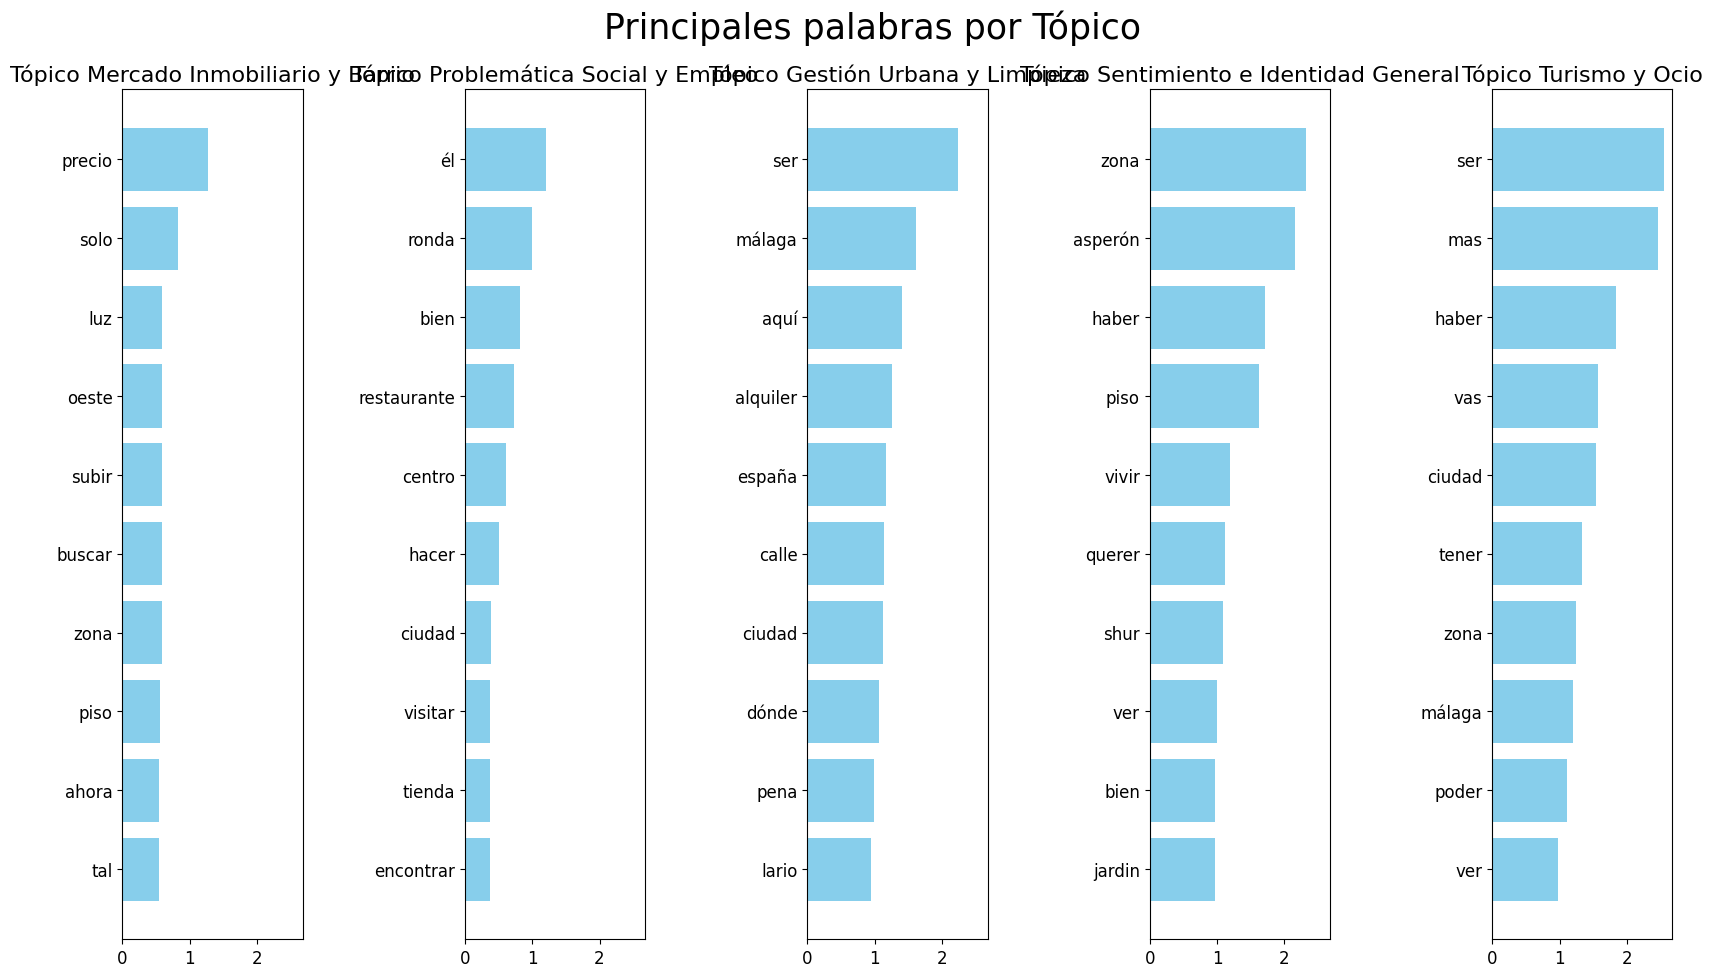

In [103]:

def plot_top_words(model, feature_names, n_top_words, title):
    # Ajustamos el grid según la cantidad de tópicos (ej. 10 tópicos en 2 filas)
    fig, axes = plt.subplots(1, 5, figsize=(20, 10), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        # Obtener los índices de las palabras con mayores pesos
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, color='skyblue')
        ax.set_title(f"Tópico {nombre_topicos[topic_idx]}", fontdict={"fontsize": 16})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=12)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    fig.suptitle(title, fontsize=25)
    plt.show()

# Ejemplo de uso:
# 'lda' es tu modelo entrenado, 'vectorizer' es tu CountVectorizer o TfidfVectorizer
tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda_model, tf_feature_names, 10, "Principales palabras por Tópico")

##5.2. Número de documentos por tópico

/tmp/ipython-input-955367360.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


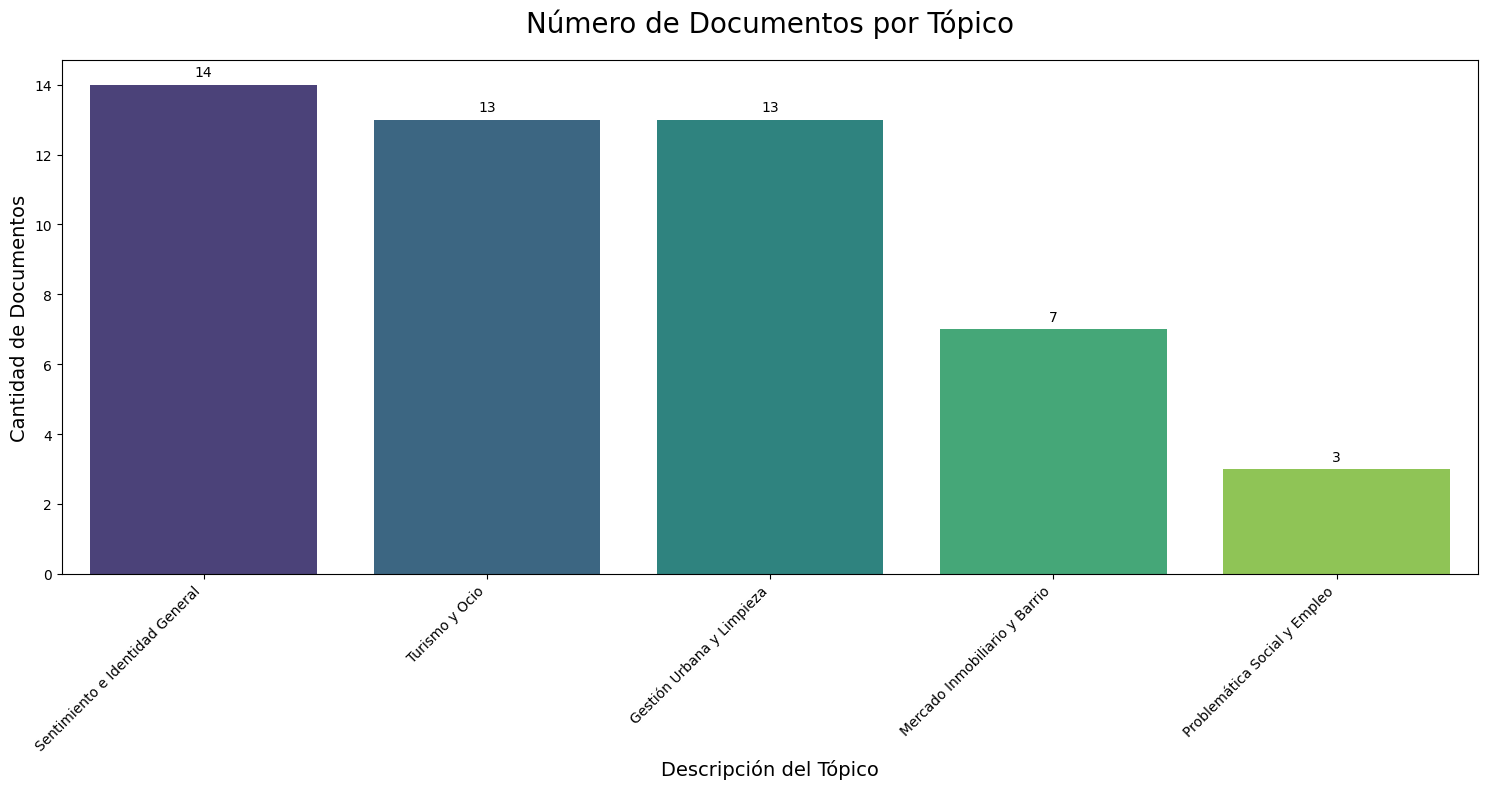

In [104]:


# 1. Configurar el tamaño del gráfico
plt.figure(figsize=(15, 8))

# 2. Crear el gráfico de conteo (Countplot)

ax = sns.countplot(
    data=df_combined,
    x='topico_desc',
    palette='viridis',
    order=df_combined['topico_desc'].value_counts().index # Ordena de mayor a menor
)

# 3. Personalización estética
plt.title('Número de Documentos por Tópico', fontsize=20, pad=20)
plt.xlabel('Descripción del Tópico', fontsize=14)
plt.ylabel('Cantidad de Documentos', fontsize=14)

# Rotar las etiquetas del eje X para que sean legibles
plt.xticks(rotation=45, ha='right')

# Añadir el número exacto encima de cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.tight_layout()
plt.show()


##6. Predicción

In [126]:
frase_nueva = "Málaga es un mal lugar para vivir. Está muy sucia y tiene precios altos."
preprocesador=Preprocessor(nlp,ruido_nuevo)
vec_nueva = vectorizer.transform([frase_nueva])

version 2.1.0


##6.1. Predicción y métricas de validación (Análisis de sentimientos - TextBlob)

In [136]:
# Empleamos un modelo de predicción Naive Bayes
y = df_combined['sentimiento_TextB']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Dividimos esl set de datos en 80% para entrenamiento y 20% para validación
clf_textb = MultinomialNB() # Instanciamos el modelo Naive Bayes
clf_textb.fit(X_train, y_train) #Entrenamos el modelo
y_pred = clf_textb.predict(X_test) # Efectuamos la predicción para la parte del dataset destinado a validación
prediccion = clf_textb.predict(vec_nueva) # Efectuamos la predicción de la polaridad para la "frase_nueva"
print(f"Predicción para '{frase_nueva}': {prediccion[0]}")

Predicción para 'Málaga es un mal lugar para vivir. Está muy sucia y tiene precios altos.': Positivo


In [137]:
# Calculamos F1 Score (usamos un nombre de variable distinto a la función)
f1_resultado = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1_resultado:.5f}")
print(classification_report(y_test,y_pred))

F1 Score: 0.71111
              precision    recall  f1-score   support

    Negativo       0.00      0.00      0.00         3
    Positivo       0.80      1.00      0.89        12

    accuracy                           0.80        15
   macro avg       0.40      0.50      0.44        15
weighted avg       0.64      0.80      0.71        15



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##6.2. Predicción y métricas de validación (Análisis de sentimientos - PySentimiento)

In [134]:
y = df_combined['sentimiento_PySent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Dividimos esl set de datos en 80% para entrenamiento y 20% para validación
clf_pysent = MultinomialNB() # Instanciamos el modelo Naive Bayes
clf_pysent.fit(X_train, y_train) #Entrenamos el modelo
y_pred = clf_pysent.predict(X_test) # Efectuamos la predicción para la parte del dataset destinado a validación
prediccion = clf_pysent.predict(vec_nueva) # Efectuamos la predicción de la polaridad para la "frase_nueva"
print(f"Predicción para '{frase_nueva}': {prediccion[0]}")

Predicción para 'Málaga es un mal lugar para vivir. Está muy sucia y tiene precios altos.': NEU


In [129]:

# Calculamos F1 Score (usamos un nombre de variable distinto a la función)
f1_resultado = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1_resultado:.5f}")
print(classification_report(y_test,y_pred))

F1 Score: 0.71111
              precision    recall  f1-score   support

    Negativo       0.00      0.00      0.00         3
    Positivo       0.80      1.00      0.89        12

    accuracy                           0.80        15
   macro avg       0.40      0.50      0.44        15
weighted avg       0.64      0.80      0.71        15



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##6.3. Predicción y métricas de validación Modelado de Tópicos (LDA)

In [133]:
y = df_combined['topico_desc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Dividimos esl set de datos en 80% para entrenamiento y 20% para validación
clf_lda = MultinomialNB() # Instanciamos el modelo Naive Bayes
clf_lda.fit(X_train, y_train) #Entrenamos el modelo
y_pred = clf_lda.predict(X_test) # Efectuamos la predicción para la parte del dataset destinado a validación
prediccion = clf_lda.predict(vec_nueva) # Efectuamos la predicción del tópico más probable para la "frase_nueva"
print(f"Predicción para '{frase_nueva}': {prediccion[0]}")

Predicción para 'Málaga es un mal lugar para vivir. Está muy sucia y tiene precios altos.': Gestión Urbana y Limpieza


In [131]:
# Calculamos F1 Score (usamos un nombre de variable distinto a la función)
f1_resultado = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1_resultado:.5f}")

F1 Score: 0.39896


#7. Conservación de los modelos generadosy descarga de los mismos

In [145]:

# Guardamos los modelos entrenados para poderlos emplear directamente en el notebook "chat_ia"
joblib.dump(clf_textb, 'text_blob_model.joblib')
joblib.dump(clf_pysent, 'py_sentiment_,model.joblib')
joblib.dump(clf_lda, 'lda_topics_model.joblib')
joblib.dump(vectorizer, 'vectorizador_tfidf.joblib')

['vectorizador_tfidf.joblib']

In [146]:
# Descargar los archivos creados
files.download('text_blob_model.joblib')
files.download('py_sentiment_,model.joblib')
files.download('lda_topics_model.joblib')
files.download('vectorizador_tfidf.joblib')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>